# About

This notebook is a template for calculating orientation selectivity in pyramidal cells. These are the steps:

	1. Rigid motion correction for the full frame: Matlab (Kaspar's code).
	2. Average the first 50 frames (after discarding LED off time) and present to the user to draw an ROI: Matlab (Kaspar's code). 
	3. Initial trace is average over user-drawn ROI. Background trace is average over not ROI. Export traces to jupyter notebook.  
	4. De-trending: Find F0 by doing a lowpass filter (F0_t = smooth(trace', 1000/length(trace),'lowess')’;) and subtract it from the trace. Do this also for a 'background' trace.
	5. High-pass filter the de-trended traces (foreground and background) by taking an FFT and discarding 0.5% of the lowest frequencies
	6. Spike detection: 

		1. Smooth data for initial detection
		2. Finding a good threshold for spike detection:  For a particular threshold, detect spikes as peaks above the threshold that are spaced at a minimum distance of 4 points (should also be dependent on frame rate). Then do this over a range of thresholds and plot the number of spikes detected as a function of threshold. Find the inflection point (maximum slope) and choose this as your threshold. 
	7. Aligning to visual stimulus: Create vector of visual stimulus on time for each of the eight conditions. Figure out how to do this in a smart way. 
	8. Bin the spikes according to trials and orientation. Plot the orientation selectivity (with error bars)

Most of these are translated from Kaspar's Matlab code.

# Setup

## Imports

In [1]:
from PIL import Image
import math
import matplotlib.path as mplPath
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import pickle
import pylab as pl
import random
np.random.seed(1)
import re
import scipy.io as spio
from scipy.optimize import curve_fit
from scipy.signal import medfilt
from scipy.signal import savgol_filter
import sys
import time



## Specify parameters

In [2]:
animal_ID = 402362
LED_off_removed = 1 # To monitor if LED off time has been removed from the traces

if animal_ID == 402362:
    cells = [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13]
    frame_rates = [500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]
elif animal_ID == 402361:
    cells = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18]
    frame_rates = [510, 500, 500, 500, 500, 500, 500, 500, 500, 500, 666, 400, 450, 450, 500, 500]


animal_folder = 'E:\ST_Voltron\{0}'.format(animal_ID)
daq_folder = 'Z:\ST-Voltron_DAQ' # Where camera TTLs and vis stim timings are stored

num_cells = len(cells)

num_preview = 100 # Number of frames to average for initial ROI drawing

binning = 4*4 # Camera setting - number of pixels binned while imaging
offset = 100 # Camera offset per pixel (in bits)

# Spike detection parameters
num_window = 20 # Size of window for detrending by piecewise linear fit = num_frames/num_window
freq_discard = 5 # Percentage of lowest frequencies to discard for high-pass filtering
num_thresh_test = 1000 # Number of spike detection thresholds to test between min and max
fpr = 0.05 # Desired false positive rate as a fraction of detected spikes
sta_time = 40 # Time in ms over which spike triggered average is calculated
min_spikes = 30 # Minimum number of spikes detected initially

# Visual stimulus parameters
dur = 400 # Approximate duration (greater than actual) of recordings in seconds
num_ori = 8
vis_freq = 1 # Temporal frequency of visual stimulus in Hz
vis_on = 1 # Stimulus on time in seconds
vis_off = 1 # Stimulus off time in seconds
num_vis_stim = int(dur/(vis_on + vis_off)) # Approximate (more than actual)
max_ori_pos = 3
ori_degrees = [-135, -90, -45, 0, 45, 90, 135, 180]

# Function definitions

## Data input

### File name sorting

In [3]:
# Sort the file names of frames in a natural ascending order without requiring 
# leading zeros 
# C is a list of filenames of individual frames to be sorted
# Frame number is the last run of digits in the filename

def filename_sort(animal_folder, cell_id):
    # Get list of filenames for frames (sorted)
    cell_folder = '{0}\Cell{1}'.format(animal_folder, cell_id)
    filenames = [f for f in os.listdir(cell_folder) if f.endswith('.tif')]
    num_frames = len(filenames)
    filenames = sort_nat_ascend(filenames, num_frames)
    return filenames, num_frames

def sort_nat_ascend(C, num_frames):
    
    C2 = [re.sub('\d', '0', str) for str in C] # Replace runs of digits with zeros
    C3 = [np.array(list(str)) for str in C2] # Convert each string to an array of chars
    digits = [str == '0' for str in C3] # Positions of digits 
    
    # Extract the start and end indices of the last run of digits (frame number)
    end = np.array([np.squeeze(digit.nonzero())[-1]  for digit in digits]) + 1
    start = [end[frame] - np.argmax(digits[frame][(end[frame] - 1):0:-1] == False) for frame in range(num_frames)]
    
    # Sort by numerical values of frame numbers
    frame_numbers = [int(C[frame][start[frame]:end[frame]]) for frame in range(num_frames)]
    return [str for _,str in sorted(zip(frame_numbers,C))] 
    

### ROI drawing and saving metadata

In [4]:
# This function also serves as the point at which all 
# metadata about the cell is saved. 

def get_ROI(animal_folder, cell_id, num_frames, num_preview, 
            filenames, frame_rate, offset, binning):
    
    
    # Make preview file - 100 frames evenly spaced in the session
    fnums = np.round(np.linspace(0, num_frames - 1, 
                                 num_preview)).astype(int)

    cell_folder = '{0}\Cell{1}'.format(animal_folder, cell_id)
    im = Image.open('{0}\{1}'.format(cell_folder, filenames[fnums[0]]))
    w, h = im.size
    preview_array = np.zeros([h, w, num_preview])

    for frame in range(num_preview):
        im = Image.open('{0}\{1}'.format(cell_folder, 
                                         filenames[fnums[frame]]))
        preview_array[:, :, frame] = np.array(im)
    preview = np.mean(preview_array, 2)
    
    %matplotlib qt
    pl.imshow(preview)
    plt.title('Click to draw polygon ROI and doubleclick when done')
    my_roi = roipoly(roicolor='r') # draw new ROI in red color
    plt.pause(20)
    mask = my_roi.getMask(preview)
    
    area = np.sum(mask)
    area_bg = w*h - area
    
    # Time vector
    time_vec = np.arange(num_frames)/frame_rate
    
    # Save data
    with open('{0}\Traces\Cell_{1}_metadata.pkl'.format(animal_folder, 
                                        cell_id), 'wb') as f:
        pickle.dump({'mask':mask, 'h':h, 'w':w, 'num_frames':num_frames, 
                     'filenames':filenames, 'area':area, 'area_bg':area_bg,
                     'frame_rate':frame_rate, 'time_vec':time_vec,
                    'offset': offset, 'binning':binning}, f)
    

In [5]:
# This code is from https://github.com/jdoepfert, 
#which can be used without permission

class roipoly:
    def __init__(self, fig=[], ax=[], roicolor='b'):
        if fig == []:
            fig = plt.gcf()

        if ax == []:
            ax = plt.gca()

        self.previous_point = []
        self.allxpoints = []
        self.allypoints = []
        self.start_point = []
        self.end_point = []
        self.line = None
        self.roicolor = roicolor
        self.fig = fig
        self.ax = ax
        #self.fig.canvas.draw()

        self.__ID1 = self.fig.canvas.mpl_connect(
            'motion_notify_event', self.__motion_notify_callback)
        self.__ID2 = self.fig.canvas.mpl_connect(
            'button_press_event', self.__button_press_callback)

        if sys.flags.interactive:
            plt.show(block=False)
        else:
            plt.show()

    def getMask(self, currentImage):
        ny, nx = np.shape(currentImage)
        #print(self.allxpoints)
        poly_verts = [(self.allxpoints[0], self.allypoints[0])]
        for i in range(len(self.allxpoints)-1, -1, -1):
            poly_verts.append((self.allxpoints[i], self.allypoints[i]))

        # Create vertex coordinates for each grid cell...
        # (<0,0> is at the top left of the grid in this system)
        x, y = np.meshgrid(np.arange(nx), np.arange(ny))
        x, y = x.flatten(), y.flatten()
        points = np.vstack((x,y)).T

        ROIpath = mplPath.Path(poly_verts)
        grid = ROIpath.contains_points(points).reshape((ny,nx))
        return grid

    def displayROI(self,**linekwargs):
        l = plt.Line2D(self.allxpoints +
                     [self.allxpoints[0]],
                     self.allypoints +
                     [self.allypoints[0]],
                     color=self.roicolor, **linekwargs)
        ax = plt.gca()
        ax.add_line(l)
        plt.draw()

    def displayMean(self,currentImage, **textkwargs):
        mask = self.getMask(currentImage)
        meanval = np.mean(np.extract(mask, currentImage))
        stdval = np.std(np.extract(mask, currentImage))
        string = "%.3f +- %.3f" % (meanval, stdval)
        plt.text(self.allxpoints[0], self.allypoints[0],
                 string, color=self.roicolor,
                 bbox=dict(facecolor='w', alpha=0.6), **textkwargs)

    def __motion_notify_callback(self, event):
        if event.inaxes:
            ax = event.inaxes
            x, y = event.xdata, event.ydata
            # Move line around
            if (event.button == None or event.button == 1) and self.line != None: 
                self.line.set_data([self.previous_point[0], x],
                                   [self.previous_point[1], y])
                self.fig.canvas.draw()


    def __button_press_callback(self, event):
        if event.inaxes:
            x, y = event.xdata, event.ydata
            ax = event.inaxes
            # If you press the left button, single click
            if event.button == 1 and event.dblclick == False:  
                if self.line == None: # if there is no line, create a line
                    self.line = plt.Line2D([x, x],
                                           [y, y],
                                           marker='o',
                                           color=self.roicolor)
                    self.start_point = [x,y]
                    self.previous_point =  self.start_point
                    self.allxpoints=[x]
                    self.allypoints=[y]

                    ax.add_line(self.line)
                    self.fig.canvas.draw()
                    # add a segment
                else: # if there is a line, create a segment
                    self.line = plt.Line2D([self.previous_point[0], x],
                                           [self.previous_point[1], y],
                                           marker = 'o',
                                           color=self.roicolor)
                    self.previous_point = [x,y]
                    self.allxpoints.append(x)
                    self.allypoints.append(y)

                    event.inaxes.add_line(self.line)
                    self.fig.canvas.draw()
            elif ((event.button == 1 and event.dblclick==True) or (event.button == 3 and event.dblclick==False)) and self.line != None: # close the loop and disconnect
                    self.fig.canvas.mpl_disconnect(self.__ID1) #joerg
                    self.fig.canvas.mpl_disconnect(self.__ID2) #joerg

                    self.line.set_data([self.previous_point[0],
                                    self.start_point[0]],
                                   [self.previous_point[1],
                                    self.start_point[1]])
                    ax.add_line(self.line)
                    self.fig.canvas.draw()
                    self.line = None

                    if sys.flags.interactive:
                        pass
                    else:
                        #figure has to be closed so that code can continue
                        plt.close(self.fig) 

### Loading data

In [6]:
def trace_from_movie(animal_folder, cell_id):
    
    # Load metadata
    with open('{0}\Traces\Cell_{1}_metadata.pkl'.format(animal_folder, 
                                                cell_id), 'rb') as f:
        md = pickle.load(f) 
    
    h = md['h']; w = md['w']; 
    num_frames = md['num_frames']; filenames = md['filenames']; 
    mask = md['mask']; area = md['area']; area_bg = md['area_bg']; 
    offset = md['offset']; binning = md['binning'];
    time_vec = md['time_vec']; frame_rate = md['frame_rate']
    
    # Load movie tifs
    cell_folder = '{0}\Cell{1}'.format(animal_folder, cell_id)
    data_array = np.zeros([h, w, num_frames])
    for frame in range(num_frames):
        if(np.mod(frame, 1000) == 0):
                    print(frame)
        im = Image.open('{0}\{1}'.format(cell_folder, filenames[frame]))
        data_array[:, :, frame] = np.array(im)
    
    # Use ROI mask to get data and background traces
    print('Calculating data trace')
    data = np.sum(data_array[mask, :], 0)
    #print('Calculating background trace')
    #background = np.sum(data_array[~mask, :], 0)
    background = np.zeros(data.shape)
    
    del data_array # Free up memory

    # Go from pixel intensity to electrons
    data = np.subtract(data, area*offset*binning)*0.48
    background = np.subtract(background, area_bg*offset*binning)*0.48

    # Save data and background traces
    with open('{0}\Traces\Cell_{1}.pkl'.format(animal_folder, 
                                               cell_id), 'wb') as f:
        pickle.dump({'data':data, 'background':background}, f)

    
    

### Remove LED_off

In [7]:
def remove_LED_off(animal_folder, cell_id):
    
    # Load metadata
    with open('{0}\Traces\Cell_{1}_metadata.pkl'.format(animal_folder, 
                                                cell_id), 'rb') as f:
        md = pickle.load(f) 
    
    h = md['h']; w = md['w']; 
    num_frames = md['num_frames']; filenames = md['filenames']; 
    mask = md['mask']; area = md['area']; area_bg = md['area_bg']; 
    offset = md['offset']; binning = md['binning'];
    time_vec = md['time_vec']; frame_rate = md['frame_rate']
    
    # Load data
    with open('{0}\Traces\Cell_{1}.pkl'.format(animal_folder, 
                                               cell_id), 'rb') as f:
        data_dict = pickle.load(f) 
        
    data = data_dict['data']
    background = data_dict['background']
    
    # Plot data 
    %matplotlib qt
    plt.plot(range(1, 10*frame_rate + 1), data[:10*frame_rate], 
             label = 'data')
    plt.title('Cell {0}: raw data from user drawn ROI'.format(cell_id))                                       
    plt.xlabel('Frames')
    plt.ylabel('Electrons summed over mask')
    plt.grid()
    plt.pause(0.2)
    
    LED_off = int(input('Cell {0}: how many frames to delete from beginning?'.format(cell_id)))
    
    # Remove LED off frames
    data_dict['data'] = data[LED_off:]
    data_dict['background'] = background[LED_off:]
    
    # Save modified traces
    with open('{0}\Traces\Cell_{1}_LED_on.pkl'.format(animal_folder, 
                                                cell_id), 'wb') as f:
        pickle.dump(data_dict, f)
    
    # Change metadata
    md['num_frames'] = len(filenames) - LED_off
    md['time_vec'] = np.arange(md['num_frames'])/frame_rate
    md['LED_off'] = LED_off
    
    filename = '{0}\Traces\Cell_{1}_metadata.pkl'.format(animal_folder, 
                                                         cell_id)
    os.remove(filename)
    with open('{0}\Traces\Cell_{1}_metadata.pkl'.format(animal_folder, 
                                                cell_id), 'wb') as f:
        pickle.dump(md, f)
       
    

## Spike detection

### De-trending

In [8]:
def detrend(animal_folder, cell_id, num_window): # num_window should be about 20
    
    # Load metadata
    with open('{0}\Traces\Cell_{1}_metadata.pkl'.format(animal_folder, cell_id), 'rb') as f:
        md = pickle.load(f) 
    
    h = md['h']; w = md['w']; num_frames = md['num_frames']; filenames = md['filenames']; mask = md['mask'];
    area = md['area']; area_bg = md['area_bg']; offset = md['offset']; binning = md['binning'];
    time_vec = md['time_vec']; frame_rate = md['frame_rate']; LED_off = md['LED_off']
    
    # Load data
    with open('{0}\Traces\Cell_{1}_LED_on.pkl'.format(animal_folder, cell_id), 'rb') as f:
        data_dict = pickle.load(f) # Data
        
    data = data_dict['data']
    background = data_dict['background']
    
    # Fit a piecewise linear curve to the data trace (F0)
    window = int(num_frames/num_window) # Should be made dependent on frame rate
    if window%2 == 0:
        window += 1
    poly = 1 # Degree of polynomial to fit
    F0 = savgol_filter(data, window, poly)
    
#     print('Cell {0} num_frames: {1}'.format(cell_id, num_frames))
#     print('Cell {0} LED_off: {1}'.format(cell_id, LED_off))
#     print('Cell {0} time_vec length: {1}'.format(cell_id, time_vec.shape))
#     print('Cell {0} data length : {1}'.format(cell_id, data.shape))
#     print('Cell {0} num_files: {1}'.format(cell_id, len(filenames)))
    

    # Plot F0
    % matplotlib qt
    plt.plot(time_vec, data, label = 'Raw data', color = 'orange', linewidth = 0.8)
    plt.plot(time_vec, F0, label = 'F0', color = 'b', linewidth = 2)
    plt.legend(loc = 'best')
    plt.title('Cell {1}: smoothed data with window size {0} frames'.format(window, cell_id))
    plt.xlabel('Time (s)')
    plt.ylabel('Electrons summed over mask')
    plt.savefig('{0}\Traces\Cell{1}_F0'.format(animal_folder, cell_id))
    
     # Calculate dF/F
    data2 = np.divide(data - F0, F0)*100
    
    # Plot dF/F
    % matplotlib qt
    plt.plot(time_vec, data2)
    plt.title('Cell {1} detrended data with window size {0} frames'.format(window, cell_id))
    plt.xlabel('Time (s)')
    plt.ylabel('dF/F (%)')
    plt.savefig('{0}\Traces\Cell{1}_dFF'.format(animal_folder, cell_id))
    
    return F0, window, data2


### High-pass filter

In [9]:
def high_pass(animal_folder, cell_id, data2, freq_discard): # freq_discard should be 5
    
    # Load metadata
    with open('{0}\Traces\Cell_{1}_metadata.pkl'.format(animal_folder, cell_id), 'rb') as f:
        md = pickle.load(f) 
    
    h = md['h']; w = md['w']; num_frames = md['num_frames']; filenames = md['filenames']; mask = md['mask'];
    area = md['area']; area_bg = md['area_bg']; offset = md['offset']; binning = md['binning'];
    time_vec = md['time_vec']; frame_rate = md['frame_rate']; LED_off = md['LED_off']
    
    data2_fft = np.fft.fft(data2)
    num_freq = int(num_frames/2) if num_frames % 2 == 0 else int((num_frames - 1)/2)
    num_freq_discard = int(freq_discard*num_freq/100)
    data2_fft[0:num_freq_discard] = 0 # Positive frequencies
    data2_fft[num_frames - num_freq_discard:] = 0 # Negative frequencies
    data3 = np.real(np.fft.ifft(data2_fft))

    # Plot high pass filtered trace
    % matplotlib qt
    plt.plot(time_vec, data3)
    plt.title('Cell {1} high pass filtered data (lowest {0}% of freqs discarded)'.format(freq_discard, cell_id))
    plt.xlabel('Time (s)')
    plt.ylabel('dF/F (%)')
    plt.savefig('{0}\Traces\Cell{1}_high_pass.png'.format(animal_folder, cell_id))
    
    return data3

### Detect spikes

#### Select threshold

In [10]:
# num_test: number of thresholds to test, about 1000 is good
# fpr = desired false positive rate in percentage

def select_threshold(animal_folder, cell_id, data3, num_test, fpr, min_spike_count):

    data4 = - data3 # Just to make things easier to read

    thresh_max = np.max(data4)
    thresh_min = 0.2*thresh_max # This will be around zero
    thresh_vals = np.arange(thresh_min, thresh_max, (thresh_max - thresh_min)/num_test)

    # Find peaks (local minima in windows of three points) in the data
    dif = np.diff(data4[:- 1], 1) # Discrete difference, ignoring last frame
    # Boolean array, true for points greater than the preceeding point
    diff_pos = dif > 0 

    # Reverse discrete difference, ignoring the first frame
    dif_rev = np.flip(np.diff(np.flip(data4, 0)[:-1], 1), 0) 
    # Boolean array, true for points greater than the following point
    diff_rev_pos = dif_rev > 0 

    peaks = np.logical_and(diff_pos, diff_rev_pos)
    troughs = np.logical_and(~diff_pos, ~diff_rev_pos)

    # Take care of the length of peaks being less than the length of data:
    peaks = np.insert(peaks, 0, False) 
    peaks = np.append(peaks, False)

    troughs = np.insert(troughs, 0, False) 
    troughs = np.append(troughs, False)

    spike_count = [np.sum(data4[peaks] > thresh) for thresh in thresh_vals]
    neg_spike_count = [np.sum(data4[troughs] < -thresh) for thresh in thresh_vals]

    fpos = np.divide(neg_spike_count, spike_count)
    try:
        # Threshold at which false positive rate falls below criterion
        thresh_opt = thresh_vals[(fpos < fpr).nonzero()[0][0]] 
    except IndexError:
        print('Minimum false positive rate is {0}%'.format(int(100*np.min(fpos))))
        thresh_opt = thresh_vals[(fpos == np.min(fpos)).nonzero()[0][0]]
        
    # If there are too few spikes for this threshold, raise threshold
    if spike_count[(thresh_vals == thresh_opt).nonzero()[0][0]] < min_spike_count:
        try:
            # Highest threshold which gives at least 30 spikes
            thresh_opt = thresh_vals[(np.array(spike_count)>min_spike_count).nonzero()[0][-1]]
            fpr = fpos[(thresh_vals == thresh_opt).nonzero()[0][0]]
            print('False positive rate changed to {0}% to have at least 30 spikes'.format(int(100*fpr)))
        except Exception as e:
            print(e)
            print('There are less than 30 spikes for all thresholds greater than {0}% dF/F'.format(thresh_min))
        
        
    %matplotlib qt
    plt.figure()
    #plt.plot(thresh_vals/thresh_max, spike_count)
    plt.plot(thresh_vals, spike_count, label = 'Positive spikes')
    plt.plot(thresh_vals, neg_spike_count, label = 'Negative spikes')
    plt.plot(np.ones(1000)*thresh_opt, np.arange(0, 4000, 4), 
             label = 'Selected threshold with {0}% false positive rate'.format(int(fpr*100)))
    plt.legend(loc = 'best', fontsize = 10)
    plt.title('Cell {0}: spikes detected vs detection threshold'.format(cell_id), fontsize = 10)
    plt.xlabel('Detection threshold (dF/F %)', fontsize = 15)
    plt.ylabel('Number of spikes', fontsize = 15)
    plt.savefig('{0}\Traces\Cell{1}_spikes_vs_thresh.png'.format(animal_folder, cell_id))
    
    return peaks, data4, thresh_opt, fpr

#### Find spike times

In [11]:
def plot_spikes(animal_folder, cell_id, peaks, data4, thresh_opt):
    
    # Load metadata
    with open('{0}\Traces\Cell_{1}_metadata.pkl'.format(animal_folder, 
                                                cell_id), 'rb') as f:
        md = pickle.load(f) 
    
    h = md['h']; w = md['w']; 
    num_frames = md['num_frames']; filenames = md['filenames']; 
    mask = md['mask']; area = md['area']; area_bg = md['area_bg']; 
    offset = md['offset']; binning = md['binning'];
    time_vec = md['time_vec']; frame_rate = md['frame_rate']; 
    LED_off = md['LED_off']
    
    spikes_binary = np.logical_and(peaks, data4 > thresh_opt)
    spike_frames = np.squeeze(spikes_binary.nonzero())
    spike_times = time_vec[spikes_binary]
    num_spikes = np.sum(spikes_binary)

    %matplotlib qt
    plt.figure()
    plt.plot(time_vec, data4, linewidth = 1, label = 'High pass filtered data',
             #marker = 'o'
            )
    plt.scatter(spike_times, (np.ones(spike_times.shape)*np.max(data4)), color = 'k')

    plt.title('Cell %d spikes' %cell_id, fontsize = 20)
    plt.xlabel('Time (s)', fontsize = 17)
    plt.ylabel('dF/F (%)', fontsize = 17)
    plt.grid()
    plt.legend(fontsize = 17)
    plt.savefig('{0}\Traces\Cell{1}_spikes'.format(animal_folder, cell_id))
    
    return num_spikes, spike_frames

### Spike triggered average

In [12]:
def find_sta(animal_folder, cell_id, sta_time, data2, spike_frames, fpr):

    # Load metadata
    with open('{0}\Traces\Cell_{1}_metadata.pkl'.format(animal_folder, 
                                                        cell_id), 'rb') as f:
        md = pickle.load(f) 
    
    h = md['h']; w = md['w']; 
    num_frames = md['num_frames']; filenames = md['filenames']; 
    mask = md['mask']; area = md['area']; area_bg = md['area_bg']; 
    offset = md['offset']; binning = md['binning'];
    time_vec = md['time_vec']; frame_rate = md['frame_rate']; 
    LED_off = md['LED_off']
    
    sta_frames = int(sta_time*frame_rate/1000)
    sta_time_vec = np.linspace(-sta_time, sta_time, sta_frames*2)
    sta_vals = [data2[(frame - sta_frames):(frame + sta_frames)] 
                for frame in spike_frames if frame > sta_frames and 
                frame < num_frames - sta_frames]                              
    sta = -np.mean(sta_vals, 0) # Negated

    sta_error = np.std(sta_vals, 0)


    %matplotlib qt
    plt.figure()
    plt.plot(sta_time_vec, sta, linewidth = 1, color = 'k')
    plt.fill_between(sta_time_vec, sta + sta_error, sta - sta_error, 
                     where=sta - sta_error <= sta + sta_error, 
                     facecolor='blue', alpha = 0.2, interpolate=True, 
                     label = 'Standard deviation')
    plt.title('Cell {0} spike triggered average from {1} spikes ({2}% false positive rate)'.format(cell_id, 
                                                               num_spikes, int(fpr*100), fontsize = 20))
    plt.xlabel('Time from spike (ms)', fontsize = 17)
    plt.ylabel('dF/F (%)', fontsize = 17)
    plt.grid()
    plt.legend(loc = 'best')
    plt.grid()
    
    plt.savefig('{0}\Traces\Cell{1}_sta_fpr_{2}'.format(animal_folder, cell_id, int(fpr*100)))
    
    return sta, sta_error

### Temporal filter

In [ ]:
def temp_filter(animal_folder, cell_id):
    
    # Load metadata
    with open('{0}\Traces\Cell_{1}_metadata.pkl'.format(animal_folder, cell_id), 'rb') as f:
        md = pickle.load(f) 
    
    h = md['h']; w = md['w']; num_frames = md['num_frames']; filenames = md['filenames']; mask = md['mask'];
    area = md['area']; area_bg = md['area_bg']; offset = md['offset']; binning = md['binning'];
    time_vec = md['time_vec']; frame_rate = md['frame_rate']; LED_off = md['LED_off']
    
    # Load spiking data
    with open('{0}\Traces\Cell_{1}_spikes.pkl'.format(animal_folder, cell_id), 'rb') as f:
        sd = pickle.load(f)
    F0 = sd['F0']; spike_frames = sd['spike_frames']; sta = sd['sta']
    num_spikes = sd['num_spikes']; data_detrend = sd['data_detrend']
    
    # Matched filter - convolve spike template with raw data
    
    
    
    'F0': F0, 'num_window': num_window, 'data_detrend': data2, 
                    'data_high_pass': data3, 'freq_discard': freq_discard, 'peaks': peaks,
                    'data_high_pass_neg': data4, 'thresh_opt': thresh_opt, 
                     'num_thresh_test': num_thresh_test, 'fpr': cell_fpr, 'num_spikes': num_spikes,
                    'spike_frames': spike_frames, 'sta': sta, 'sta_error': sta_error
    

### Spatial filter

In [ ]:
def sp_filter(animal_folder, cell_id):

## Orientation selectivity

### Get visual stimulus and camera timings

In [13]:
# 'cell' should be between 0 and num_cells - 1
# 'marker_style' should be 'o' or None
# 'offset' is a period with inncorrect TTLs to be ignored in seconds
# 'ax' is the plotting axes handle

def onclick(event):
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))

    cid = fig.canvas.mpl_connect('button_press_event', onclick)

def get_daq(animal_ID, daq_folder, cell_id):
    
    filename = '{0}\ANM{1}_cell{2}_DAQ'.format(daq_folder, 
                                               animal_ID, cell_id)
    mat = spio.loadmat(filename, squeeze_me=True)
    
    vis_stim = np.array(mat['data'][:, 0])
    camera_output = np.array(mat['data'][:, 1])
    daq_rate = mat['rate']
    daq_time_vec = mat['timeStamps']
    
    return vis_stim, camera_output, daq_rate, daq_time_vec
    
def plot_camera(animal_folder, cell_id, start_time, end_time, marker_style,
               daq_rate, daq_time_vec, camera_output):
    
    start_point = int(start_time*daq_rate)
    end_point = int(end_time*daq_rate)
    
    %matplotlib qt
    plt.figure()
    plt.plot(
            daq_time_vec[start_point:end_point],
            camera_output[start_point:end_point],
            marker = marker_style
            )
    plt.title('Cell {0} camera TTLs'.format(cell_id))
    plt.pause(5)
    offset = int(input('After what time to look for the first frame?'))
    plt.savefig('{0}\Vis_stim_info\Cell{1}_camera.png'.format(animal_folder, cell_id))
    
    return offset

    
def find_frame_times(cell_id, offset, camera_output, daq_rate):

    camera_output = camera_output[int(offset*daq_rate):]
    
    high_pts = np.array((camera_output > 0.2).nonzero())
    camera_output[high_pts] = 1
    
    low_pts = np.array((camera_output < 0.2).nonzero())
    camera_output[low_pts] = 0
    
    dif = np.diff(camera_output, 1)
    # Camera frame on times, in terms of daq data points
    frame_times = np.array((dif == 1).nonzero()) + offset*daq_rate
    
    
    %matplotlib qt
    plt.figure()
    
    plt.plot(daq_time_vec[int(offset*daq_rate):], camera_output)
    plt.scatter(daq_time_vec[frame_times], np.ones(frame_times.shape)*np.max(camera_output)*1.1, 
                color = 'k', marker = 'o')
    plt.title('Cell {0}  frames'.format(cell_id))
    
    return frame_times

def plot_vis(animal_folder, cell_id, start_time, end_time, marker_style, 
             daq_rate, vis_stim):

    start_point = int(start_time*daq_rate)
    end_point = int(end_time*daq_rate)       
    
    %matplotlib qt
    plt.figure()
    plt.plot(range(start_point, end_point), 
             vis_stim[start_point:end_point],
            marker = marker_style
            )
    plt.title('Cell {0} visual stimulus'.format(cell_id))
    plt.pause(30)
    
    plt.savefig('{0}\Vis_stim_info\Cell{1}_vis_stim.png'.format(animal_folder, cell_id))
    
    
def vis_start(cell_id, daq_rate, num_vis_stim, vis_on, vis_off, 
              frame_times, num_ori):
    
    # Ask user for visual stimulus start point
    vis_stim_start_point = int(input('Enter visual stimulus start frame'))
     
    # Find the time and orientation of first visual stimulus during imaging
    vis_stim_start_time = vis_stim_start_point/daq_rate

    # Jitter in the DAQ acquisition times is less than 5e-14 seconds, 
    #hence we can do this:
    trial_start_times = np.arange(vis_stim_start_point, 
                             num_vis_stim*((vis_on + vis_off)*daq_rate), 
                             (vis_on + vis_off)*daq_rate)

    pre_imaging_stim = (trial_start_times < frame_times[0][0]).nonzero()
    first_stim_num = pre_imaging_stim[0][-1]
    first_stim_time = trial_start_times[first_stim_num]
    # Ori goes from 0 to 7
    first_ori = np.mod(first_stim_num, num_ori - 1)
    
    return vis_stim_start_point, vis_stim_start_time, trial_start_times, first_stim_num, first_stim_time, first_ori
    
def plot_vis_start_times(cell_id, daq_time_vec, vis_stim, stim_on_time):
        
    plt.plot(daq_time_vec, vis_stim)

    stim_on = np.zeros(vis_stim.shape) + 0.15
    stim_on[stim_on_time.astype(int)] = 0.25

    %matplotlib qt
    plt.figure()
    plt.plot(daq_time_vec, stim_on)
    plt.show()
    plt.title('Cell {0} vis stim trial start times'.format(cell_id))
    plt.pause(2)
    

### Bin frames by orientation

In [14]:
# Find the camera frames corresponding to trials and ITIs for each orientation
def find_ori_frames(animal_folder, cell_id):
    
    # Load vis stim data
    with open('{0}\Vis_stim_info\Cell_{1}_vis_stim.pkl'.format(animal_folder, cell_id), 'rb') as f:
        v = pickle.load(f)
    
    daq_rate= v['daq_rate']; trial_start_times = v['trial_start_times']; frame_times = v['frame_times']
    first_stim_time = v['first_stim_time']; first_ori = v['first_ori']; first_stim_num = v['first_stim_num']
    
#     vis_stim = v['vis_stim'], camera_output = v['camera_output'], 
#     daq_time_vec = v['daq_time_vec'], offset = v['offset'], 
#     vis_stim_start_point = v['vis_stim_start_point'], vis_stim_start_time = v['vis_stim_start_time']    
        
    # Load metadata
    with open('{0}\Traces\Cell_{1}_metadata.pkl'.format(animal_folder, cell_id), 'rb') as f:
        md = pickle.load(f) 
    
    h = md['h']; w = md['w']; num_frames = md['num_frames']; filenames = md['filenames']; mask = md['mask'];
    area = md['area']; area_bg = md['area_bg']; offset = md['offset']; binning = md['binning'];
    time_vec = md['time_vec']; frame_rate = md['frame_rate']; LED_off = md['LED_off']
    
    # There are some extra TTLs as compared to actually recorded frames. 
    # These amount to about 40ms of imaging time.
    # We will assume, for now, that the last 40ms of TTLs are spurious. 
    frame_times_trunc = frame_times[0][:(num_frames + LED_off)]
    
    # Leave out the first trial because camera would have started in the middle
    first_trial_time = first_stim_time + (vis_on + vis_off)*daq_rate
    first_trial_num = first_stim_num + 1
    first_ori = np.mod(first_ori + 1, num_ori)
    
    first_trial_ori = np.roll(range(num_ori), first_ori)
    trial_times_ori = [trial_start_times[first_trial_ori[ori]::num_ori] for ori in range(num_ori)]
    frames_ori = np.zeros([num_ori, num_frames + LED_off])
    frames_iti_ori = np.zeros([num_ori, num_frames + LED_off])
    for ori in range(num_ori):    
        for time in trial_times_ori[ori]:
            frames_ori[ori][(frame_times_trunc > time).nonzero()[0]] = 1
            frames_ori[ori][(frame_times_trunc > time + vis_on*daq_rate).nonzero()[0]] = 0
            frames_iti_ori[ori][(frame_times_trunc > time + vis_on*daq_rate).nonzero()[0]] = 1
            frames_iti_ori[ori][(frame_times_trunc > time + (vis_on + vis_off)*daq_rate).nonzero()[0]] = 0
            
    # Find the number of times all orientations are repeated
    num_rep = int((trial_start_times.shape - first_trial_num)/num_ori)
    
    # Find the first camera frame for each repetition
    rep_dur = num_ori*(vis_on + vis_off)*daq_rate
    rep_times = np.arange(first_trial_time, first_trial_time + (num_rep + 2)*rep_dur, rep_dur) 
    rep_frames = np.zeros(num_rep + 1)
    for rep in range(num_rep + 1):
        try:
            rep_frames[rep] = (frame_times_trunc > rep_times[rep]).nonzero()[0][0]
        except IndexError as e:
            print(e)
            rep_frames[rep] = 0
        
    return [frames_ori, frames_iti_ori, first_trial_ori, first_trial_time, 
            first_trial_num, first_ori, num_rep, rep_frames]

### Bin spikes by orientation 

In [15]:
def find_ori_spikes(animal_folder, cell_id, frames_ori, iti_frames_ori, num_rep, rep_frames):
    
    # Load metadata
    with open('{0}\Traces\Cell_{1}_metadata.pkl'.format(animal_folder, cell_id), 'rb') as f:
        md = pickle.load(f) 
    
    h = md['h']; w = md['w']; num_frames = md['num_frames']; filenames = md['filenames']; mask = md['mask'];
    area = md['area']; area_bg = md['area_bg']; offset = md['offset']; binning = md['binning'];
    time_vec = md['time_vec']; frame_rate = md['frame_rate']; LED_off = md['LED_off']
    
    # Load spiking data
    with open('{0}\Traces\Cell_{1}_spikes.pkl'.format(animal_folder, cell_id), 'rb') as f:
        sd = pickle.load(f)
    F0 = sd['F0']; spike_frames = sd['spike_frames'] + LED_off # Spike frames as if starting from first camera frame
    num_spikes = sd['num_spikes']
    
    spikes_ori = np.zeros([num_ori, num_rep])
    spikes_iti_ori = np.zeros([num_ori, num_rep])
    for ori in range(num_ori):    
        for rep in range(num_rep):
            spikes_rep = spike_frames[spike_frames > rep_frames[rep]]
            spikes_rep = spikes_rep[spikes_rep < rep_frames[rep + 1]]
            spikes_ori[ori][rep] = len(frames_ori[ori][spikes_rep].nonzero()[0])
            spikes_iti_ori[ori][rep] = len(frames_iti_ori[ori][spikes_rep].nonzero()[0])
    
    return spikes_ori, spikes_iti_ori, num_spikes
            
    

### Plot orientation selectivity for all cells

In [16]:
def plot_os(animal_folder, spikes_ori, spikes_iti_ori, num_rep):
    # spikes_ori, spikes_iti_ori should be dictionaries with keys as cell_id 
    # num_rep should be a num_cellsX1 array
    
    %matplotlib qt
    plt.figure()
    
    labels = []
    
    for cell_id in cells:
        try:
            mean_spikes_ori = np.mean(spikes_ori['{0}'.format(cell_id)], 1) # Average over repetitions
            sd_spikes_ori = np.std(spikes_ori['%d' %cell_id], 1) # Error bars
        except Exception as e:
            print(e)
            mean_spikes_ori = np.zeros(num_ori)
            sd_spikes_ori = np.zeros(num_ori)
        ori_max = np.argmax(mean_spikes_ori)
        ori_order = np.roll(range(num_ori), max_ori_pos - ori_max)
        plt.errorbar(ori_degrees, mean_spikes_ori[ori_order], sd_spikes_ori[ori_order], marker = 'o')
        labels.append('Cell %d' %(cell_id))
    
    plt.title('Orientation selectivity from spikes, {0}-{1} repetitions'.format(np.min(num_rep), np.max(num_rep)))
    plt.ylabel('Number of spikes per trial')
    plt.xlabel('Degrees away from preferred orientation')
    plt.legend(labels, fontsize = 20)

# Load data

## Get ROIs from user

In [17]:
for cell_id in cells:
    print('Cell {0}'.format(cell_id))
    # If metadata already exists, don't do it again
    filename = '{0}\Traces\Cell_{1}_metadata.pkl'.format(animal_folder, cell_id)
    file = Path(filename)
    if file.is_file():
        continue
    else:
        # Sort filenames
        print('Sorting filenames')
        filenames, num_frames = filename_sort(animal_folder, cell_id)
        
        # Get ROI and save all metadata
        mask, h, w, area, area_bg = get_ROI(animal_folder, cell_id, num_frames, num_preview, 
                                            filenames, frame_rates[cells.index(cell_id)], offset, binning)


Cell 1
Cell 2
Cell 3
Cell 4
Cell 5
Cell 6
Cell 9
Cell 10
Cell 11
Cell 12
Cell 13


In [18]:
# Check masks
for cell_id in cells:
    with open('{0}\Traces\Cell_{1}_metadata.pkl'.format(animal_folder, cell_id), 'rb') as f:
        md = pickle.load(f) # Metadata
    mask = md['mask']
    plt.figure()
    plt.title('Cell {0}'.format(cell_id))
    pl.imshow(mask)


## Get ROI traces from movies

In [28]:
for cell in range(num_cells):
    cell_id = cells[cell]
    print('Cell {0}'.format(cell_id))
    # If data trace already exists, don't do it again
    filename = '{0}\Traces\Cell_{1}.pkl'.format(animal_folder, cell_id)
    file = Path(filename)
    if file.is_file():
        continue
    else:
        trace_from_movie(animal_folder, cell_id)
        
    

Cell 1
Cell 2
Cell 3
Cell 4
Cell 5
Cell 6
Cell 9
Cell 10
Cell 11
Cell 12
Cell 13


## Remove LED off time

In [29]:

# Check LED_off removed for all cells
if not LED_off_removed:
    for cell in range(num_cells):
        cell_id = cells[cell]
        print('Cell {0}'.format(cell_id))
        remove_LED_off(animal_folder, cell_id)
    LED_off_removed = int(input('LED_off removed? 1 if yes, 0 if no'))


# Check LED_off removed for individual cells:
# for cell in range(num_cells):
#     cell_id = cells[cell]
#     print('Cell {0}'.format(cell_id))
#     # If data trace with LED off time removed already exists, don't do it again
#     filename = '{0}\Traces\Cell_{1}_LED_on.pkl'.format(animal_folder, cell_id)
#     file = Path(filename)
#     if file.is_file():
#         continue
#     else:
#         remove_LED_off(animal_folder, cells[cell])


# Spike detection

In [18]:
for cell in range(num_cells):
    
    cell_id = cells[cell]
    print('Cell {0}'.format(cell_id))
    F0, window, data2 = detrend(animal_folder, cell_id, num_window)
    data3 = high_pass(animal_folder, cell_id, data2, freq_discard)
    peaks, data4, thresh_opt, cell_fpr = select_threshold(animal_folder, 
                                                cell_id, data3, num_thresh_test, 
                                                fpr, min_spikes)
    num_spikes, spike_frames = plot_spikes(animal_folder, cell_id, peaks, data4, thresh_opt)
    print('{0} spikes'.format(num_spikes))
    sta, sta_error = find_sta(animal_folder, cell_id, sta_time, data2, spike_frames, cell_fpr)
    
    # Save data 
    with open('{0}\Traces\Cell_{1}_spikes.pkl'.format(animal_folder, cell_id), 'wb') as f:
        pickle.dump({'F0': F0, 'num_window': num_window, 'data_detrend': data2, 
                    'data_high_pass': data3, 'freq_discard': freq_discard, 'peaks': peaks,
                    'data_high_pass_neg': data4, 'thresh_opt': thresh_opt, 
                     'num_thresh_test': num_thresh_test, 'fpr': cell_fpr, 'num_spikes': num_spikes,
                    'spike_frames': spike_frames, 'sta': sta, 'sta_error': sta_error}, f)

Cell 2
False positive rate changed to 32% to have at least 30 spikes
31 spikes
Cell 3
False positive rate changed to 156% to have at least 30 spikes
32 spikes
Cell 4


KeyboardInterrupt: 

# Spatio-temporal filtering

In [ ]:
num_iter = 2
for cell_id in cells:
    
    for iter in range(num_iter):
        temp_filter(animal_folder, cell_id)
        sp_filter(animal_folder, cell_id)

# Visual stimulus alignment

In [20]:
for cell_id in cells:
    print('Cell %d' %cell_id)
    vis_stim, camera_output, daq_rate, daq_time_vec = get_daq(animal_ID, daq_folder, cell_id)

    offset = plot_camera(animal_folder, cell_id, 0, 200, None,
                   daq_rate, daq_time_vec, camera_output)

    frame_times = find_frame_times(cell_id, offset, camera_output, daq_rate)

    plot_vis(animal_folder, cell_id, 0, 30, 'o', 
                 daq_rate, vis_stim)

    vis_stim_start_point, vis_stim_start_time, trial_start_times, first_stim_num, first_stim_time, first_ori = vis_start(cell_id, 
                                                                                daq_rate, num_vis_stim, vis_on, vis_off, 
                                                                                  frame_times, num_ori)

    plot_vis_start_times(cell_id, daq_time_vec, vis_stim, trial_start_times)
    
    # Save data 
    with open('{0}\Vis_stim_info\Cell_{1}_vis_stim.pkl'.format(animal_folder, cell_id), 'wb') as f:
        pickle.dump({'vis_stim': vis_stim, 'camera_output': camera_output, 'daq_rate': daq_rate, 
                    'daq_time_vec': daq_time_vec, 'offset': offset, 'frame_times': frame_times,
                    'vis_stim_start_point': vis_stim_start_point, 'vis_stim_start_time': vis_stim_start_time, 
                    'trial_start_times': trial_start_times, 'first_stim_num': first_stim_num, 

                     'first_stim_time': first_stim_time, 'first_ori': first_ori}, f)

Cell 1
After what time to look for the first frame?40
Enter visual stimulus start frame137791
Cell 2
After what time to look for the first frame?25
Enter visual stimulus start frame89890
Cell 3
After what time to look for the first frame?25
Enter visual stimulus start frame95246
Cell 4
After what time to look for the first frame?50
Enter visual stimulus start frame111069
Cell 5
After what time to look for the first frame?30
Enter visual stimulus start frame90325
Cell 6
After what time to look for the first frame?25
Enter visual stimulus start frame99279
Cell 9
After what time to look for the first frame?25
Enter visual stimulus start frame85721
Cell 10
After what time to look for the first frame?25
Enter visual stimulus start frame83227
Cell 11
After what time to look for the first frame?25
Enter visual stimulus start frame98798
Cell 12
After what time to look for the first frame?25
Enter visual stimulus start frame87334
Cell 13
After what time to look for the first frame?25
Enter visu

# Orientation selectivity

In [23]:
spikes_ori = {'{0}'.format(cell_id):[] for cell_id in cells}
spikes_iti_ori = {'{0}'.format(cell_id):[] for cell_id in cells}
num_rep = np.zeros(num_cells)
num_spikes = np.zeros(num_cells)

for cell_id in cells:
    cell = cells.index(cell_id)
    
    # Bin camera frames by orientation
    [frames_ori, frames_iti_ori, first_trial_ori, first_trial_time, 
     first_trial_num, first_ori, num_rep[cell], rep_frames] = find_ori_frames(animal_folder, cell_id)
    
    # Bin spikes by orientation
    spikes_ori['%d' %cell_id], spikes_iti_ori['%d' %cell_id], num_spikes[cell] = find_ori_spikes(animal_folder, 
                                                                                                 cell_id, frames_ori, 
                                       frames_iti_ori, int(num_rep[cell]), rep_frames)
    print('Cell {0}: {1} spikes'.format(cell_id, num_spikes[cell]))

# Plot orientation selectivity
plot_os(animal_folder, spikes_ori, spikes_iti_ori, num_rep)

    

Cell 1: 31.0 spikes
Cell 2: 31.0 spikes
Cell 3: 32.0 spikes
Cell 4: 48.0 spikes
Cell 5: 31.0 spikes
Cell 6: 32.0 spikes
Cell 9: 31.0 spikes
Cell 10: 711.0 spikes
Cell 11: 31.0 spikes
Cell 12: 31.0 spikes
Cell 13: 31.0 spikes


# Playground

In [26]:
cell_id = 2
# Load spiking data
with open('{0}\Traces\Cell_{1}_spikes.pkl'.format(animal_folder, cell_id), 'rb') as f:
    sd = pickle.load(f)
F0 = sd['F0']; spike_frames = sd['spike_frames']; sta = sd['sta']
num_spikes = sd['num_spikes']; data_detrend = sd['data_detrend']

# Load data
with open('{0}\Traces\Cell_{1}_LED_on.pkl'.format(animal_folder, cell_id), 'rb') as f:
    data_dict = pickle.load(f) # Data

data = data_dict['data']
background = data_dict['background']

# Load metadata
with open('{0}\Traces\Cell_{1}_metadata.pkl'.format(animal_folder, cell_id), 'rb') as f:
    md = pickle.load(f) 

h = md['h']; w = md['w']; num_frames = md['num_frames']; filenames = md['filenames']; mask = md['mask'];
area = md['area']; area_bg = md['area_bg']; offset = md['offset']; binning = md['binning'];
time_vec = md['time_vec']; frame_rate = md['frame_rate']; LED_off = md['LED_off']


<IPython.core.display.Javascript object>


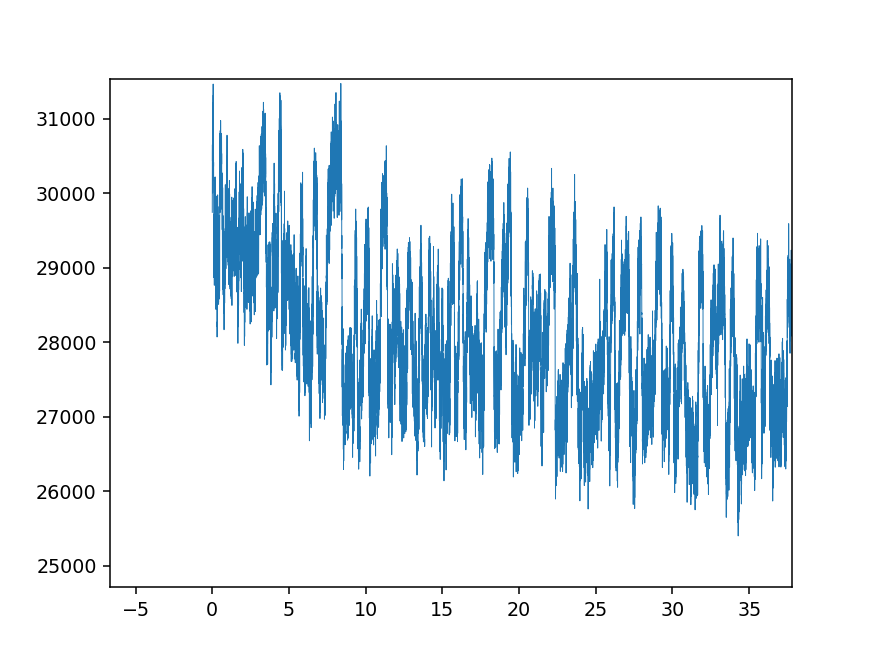

In [27]:
%matplotlib notebook
plt.figure()
#plt.plot(sd['data_detrend'])
plt.plot(time_vec, data, linewidth = 0.5)